In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import ipywidgets as widgets

In [3]:
# file download link for data from 4th grade SIMCE
file_download_link = "https://drive.usercontent.google.com/download?id=14cr_NcbnRlxGBAE2KwluXO5RWcV7h27a&export=download&authuser=0&confirm=t&uuid=ab338839-bb46-415c-9e0b-baa349f66125&at=ALWLOp58TXtgKEDFavl5Kn2Hru6H:1762816912784"

In [4]:
!wget -O RBDSimce4toBasico2014-2024.xlsx --no-check-certificate "$file_download_link"

--2025-11-29 16:51:54--  https://drive.usercontent.google.com/download?id=14cr_NcbnRlxGBAE2KwluXO5RWcV7h27a&export=download&authuser=0&confirm=t&uuid=ab338839-bb46-415c-9e0b-baa349f66125&at=ALWLOp58TXtgKEDFavl5Kn2Hru6H:1762816912784
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 2800:3f0:4003:c02::84, 172.217.192.132
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|2800:3f0:4003:c02::84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11168851 (11M) [application/octet-stream]
Saving to: ‘RBDSimce4toBasico2014-2024.xlsx’

RBDSimce4toBasico20 100%[===================>]  10.65M  46.6MB/s    in 0.2s    

2025-11-29 16:52:12 (46.6 MB/s) - ‘RBDSimce4toBasico2014-2024.xlsx’ saved [11168851/11168851]



In [5]:
#load data from the SIMCE 4th grade results from 2014 to 2024 (2019, 2020 and 2021 no test was applied)

#loads data from 2014
df_simce_2014 = pd.read_excel('RBDSimce4toBasico2014-2024.xlsx', sheet_name='2014')

#loads data from 2015
df_simce_2015 = pd.read_excel('RBDSimce4toBasico2014-2024.xlsx', sheet_name='2015')

#loads data from 2016
df_simce_2016 = pd.read_excel('RBDSimce4toBasico2014-2024.xlsx', sheet_name='2016')

#loads data from 2017
df_simce_2017 = pd.read_excel('RBDSimce4toBasico2014-2024.xlsx', sheet_name='2017')

#loads data from 2018
df_simce_2018 = pd.read_excel('RBDSimce4toBasico2014-2024.xlsx', sheet_name='2018')

#loads data from 2022
df_simce_2022 = pd.read_excel('RBDSimce4toBasico2014-2024.xlsx', sheet_name='2022')

#loads data from 2023
df_simce_2023 = pd.read_excel('RBDSimce4toBasico2014-2024.xlsx', sheet_name='2023')

#loads data from 2024
df_simce_2024 = pd.read_excel('RBDSimce4toBasico2014-2024.xlsx', sheet_name='2024')

/Users/diegosarricolea/miniconda3/envs/vis/lib/python3.14/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/diegosarricolea/miniconda3/envs/vis/lib/python3.14/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/diegosarricolea/miniconda3/envs/vis/lib/python3.14/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/diegosarricolea/miniconda3/envs/vis/lib/python3.14/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/diegosarricolea/miniconda3/envs/vis/lib/python3.14/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/diegosarricolea/miniconda3/envs/vis/lib/python3.14/site-pa

In [6]:
#count columns from data from 2014 to 2024 and check if they are the same
columns_2014 = set(df_simce_2014.columns)
columns_2015 = set(df_simce_2015.columns)
columns_2016 = set(df_simce_2016.columns)
columns_2017 = set(df_simce_2017.columns)
columns_2018 = set(df_simce_2018.columns)
columns_2022 = set(df_simce_2022.columns)
columns_2023 = set(df_simce_2023.columns)
columns_2024 = set(df_simce_2024.columns)
common_columns = columns_2014 & columns_2015 & columns_2016 & columns_2017 & columns_2018 & columns_2022 & columns_2023 & columns_2024
print(f'Common columns across all years: {common_columns}')
print(f'Number of common columns: {len(common_columns)}')
#merge all dataframes into a single dataframe if columns are the same
if len(common_columns) == len(columns_2014):
    df_simce_all_years = pd.concat([df_simce_2014, df_simce_2015, df_simce_2016, df_simce_2017, df_simce_2018, df_simce_2022, df_simce_2023, df_simce_2024], ignore_index=True)
    print('Dataframes merged successfully.')
else:
    print('Columns do not match across all years. Cannot directly merge dataframes.')
    #show columns that are different
    different_columns = {
        '2014': columns_2014 - common_columns,
        '2015': columns_2015 - common_columns,
        '2016': columns_2016 - common_columns,
        '2017': columns_2017 - common_columns,
        '2018': columns_2018 - common_columns,
        '2022': columns_2022 - common_columns,
        '2023': columns_2023 - common_columns,
        '2024': columns_2024 - common_columns
    }
    for year, cols in different_columns.items():
        print(f'Columns in {year} not in common: {cols}')
        common_columns_list = list(common_columns)
        #merge the columns that are the same
    df_simce_all_years = pd.concat([df_simce_2014[common_columns_list], df_simce_2015[common_columns_list], df_simce_2016[common_columns_list], df_simce_2017[common_columns_list], df_simce_2018[common_columns_list], df_simce_2022[common_columns_list], df_simce_2023[common_columns_list], df_simce_2024[common_columns_list]], ignore_index=True)
    print('Dataframes merged successfully.')

Common columns across all years: {'siggru_mate4b_rbd', 'difgru_mate4b_rbd', 'dvrbd', 'palu_eda_ins_mate4b_rbd', 'difgru_lect4b_rbd', 'marcadif_mate4b_rbd', 'nalu_lect4b_rbd', 'palu_eda_ins_lect4b_rbd', 'cod_rural_rbd', 'agno', 'sigdif_lect4b_rbd', 'palu_eda_ele_lect4b_rbd', 'palu_eda_ele_mate4b_rbd', 'nalu_mate4b_rbd', 'prom_mate4b_rbd', 'marcadif_lect4b_rbd', 'nom_pro_rbd', 'palu_eda_ade_lect4b_rbd', 'dif_lect4b_rbd', 'nom_reg_rbd', 'noaplica', 'dif_mate4b_rbd', 'marca_lect4b_rbd', 'palu_eda_ade_mate4b_rbd', 'cod_pro_rbd', 'prom_lect4b_rbd', 'cod_grupo', 'nom_rbd', 'cod_reg_rbd', 'siggru_lect4b_rbd', 'cod_depe2', 'nom_com_rbd', 'grado', 'rbd', 'marca_mate4b_rbd', 'cod_depe1', 'sigdif_mate4b_rbd', 'cod_com_rbd'}
Number of common columns: 38
Columns do not match across all years. Cannot directly merge dataframes.
Columns in 2014 not in common: {'marca_eda_soc4b_rbd', 'marca_soc4b_rbd', 'siggru_soc4b_rbd', 'difgru_soc4b_rbd', 'prom_soc4b_rbd', 'nom_reg_rbd_2014', 'cod_com_rbd_2014', 'dif

In [7]:
df_simce_all_years.describe()

,difgru_mate4b_rbd,dvrbd,palu_eda_ins_mate4b_rbd,difgru_lect4b_rbd,nalu_lect4b_rbd,palu_eda_ins_lect4b_rbd,agno,palu_eda_ele_lect4b_rbd,palu_eda_ele_mate4b_rbd,nalu_mate4b_rbd,prom_mate4b_rbd,palu_eda_ade_lect4b_rbd,dif_lect4b_rbd,dif_mate4b_rbd,palu_eda_ade_mate4b_rbd,cod_pro_rbd,prom_lect4b_rbd,cod_reg_rbd,rbd,cod_com_rbd
count,49428.000000,59189.000000,44360.000000,49416.000000,58487.000000,44328.000000,59189.000000,44328.000000,44360.000000,58487.000000,54820.000000,44328.000000,48101.000000,48119.000000,44360.000000,59189.000000,54856.000000,59189.000000,59189.000000,59189.000000
mean,-1.899672,4.480647,37.881506,-1.196596,29.274163,29.960959,2018.543513,26.191565,34.287193,29.451451,244.972601,34.798946,1.556392,0.982647,18.854612,47.044518,258.037571,9.005643,9610.434152,6924.199294
std,20.248251,2.881179,23.871446,18.574622,30.130788,19.483667,3.594657,12.511650,15.888895,30.342481,44.664989,20.736994,19.208006,19.037830,17.755270,52.677725,44.608976,3.611760,8201.773237,5106.261046
min,-141.000000,0.000000,0.000000,-133.000000,0.000000,0.000000,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-118.000000,-118.000000,0.000000,1.000000,0.000000,1.000000,5.000000,1.000000
25%,-14.000000,2.000000,19.000000,-12.000000,6.000000,15.400000,2015.000000,20.000000,26.500000,6.000000,230.000000,20.500000,-9.000000,-9.000000,5.600000,1.000000,245.000000,6.000000,3448.000000,48.000000
50%,0.000000,4.000000,38.500000,0.000000,21.000000,29.000000,2017.000000,27.500000,36.800000,21.000000,249.000000,34.400000,0.000000,0.000000,14.300000,7.000000,263.000000,9.000000,7496.000000,7401.000000
75%,10.000000,7.000000,55.600000,9.000000,40.000000,43.200000,2022.000000,34.000000,45.100000,40.000000,268.000000,48.700000,12.000000,11.000000,27.500000,91.000000,280.000000,13.000000,12682.000000,11101.000000
max,108.000000,9.000000,100.000000,124.000000,284.000000,100.000000,2024.000000,80.000000,85.700000,282.000000,376.000000,100.000000,137.000000,113.000000,100.000000,163.000000,396.000000,16.000000,42261.000000,16305.000000


In [11]:
df_simce_all_years.rename(columns={'nom_reg_rbd': 'Region', 'nom_com_rbd': 'Comuna', 'prom_lect4b_rbd': 'Avg Reading Score'}, inplace=True)
df_simce_all_years['Region']

0        REGIÓN ARICA - PARINACOTA
1        REGIÓN ARICA - PARINACOTA
2        REGIÓN ARICA - PARINACOTA
3        REGIÓN ARICA - PARINACOTA
4        REGIÓN ARICA - PARINACOTA
                   ...            
59184              DE LA ARAUCANÍA
59185                   DEL BIOBÍO
59186                   DEL BIOBÍO
59187    DEL LIBERTADOR BERNARDO O
59188    DEL LIBERTADOR BERNARDO O
Name: Region, Length: 59189, dtype: object

Number of cities found in Región Metropolitana de Santiago: 52


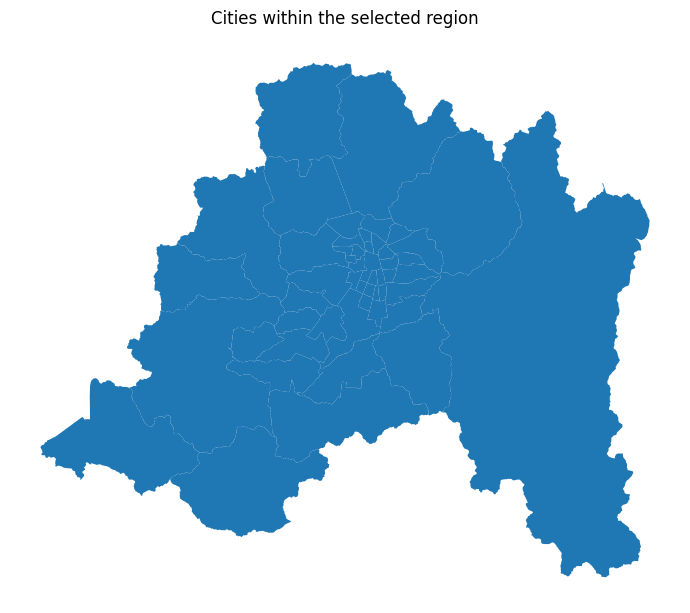

In [22]:
#gdf_regions = gpd.read_file('Regional.shp',encoding='utf-8')
gdf_cities = gpd.read_file('comunas.shp', encoding='utf-8')

# Example workflow to select a specific region and its cities from shapefiles

# --- 1) Select the region you want (by code or name) ---
# Example: by code
target_name = "Región Metropolitana de Santiago"  # Región Metropolitana de Santiago, adjust to yours
#region = gdf_regions.loc[gdf_regions["Region"] == target_name].copy()

# --- 2) Filter cities that lie inside the selected region ---
#Based on the name of the Region column in the cities shapefile
cities_in_region = gdf_cities[gdf_cities['Region'] == target_name]

# --- 3) Plot the region and its cities; zoom to the region extent ---
fig, ax = plt.subplots(figsize=(7, 7))
#region.plot(ax=ax, color="#e8eff7", edgecolor="black", linewidth=1)
cities_in_region.plot(ax=ax, markersize=15)
#print how many cities were found in the region
print(f'Number of cities found in {target_name}: {len(cities_in_region)}')

# Zoom to region with a small padding
#minx, miny, maxx, maxy = region.total_bounds
#pad_x = (maxx - minx) * 0.05
#pad_y = (maxy - miny) * 0.05
#ax.set_xlim(minx - pad_x, maxx + pad_x)
#ax.set_ylim(miny - pad_y, maxy + pad_y)

#addd the title
ax.set_axis_off()
ax.set_title("Cities within the selected region", pad=10)
plt.tight_layout()
plt.show()